In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopandas as gpd
import geodatasets
import os



In [2]:
# Load dataset
file_path = "../data/public_emdat_custom_request_2018-2024.xlsx"
df = pd.read_excel(file_path)

os.makedirs('../images/07_distribution', exist_ok=True)

print(f"Data Shape: {df.shape}")
df.head(3)


Data Shape: (4014, 47)


,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,GADM Admin Units,Entry Date,Last Update
0,2018-0040-BRA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),DFO:4576,NaN,BRA,...,NaN,NaN,NaN,10000.0,12492.0,80.049596,"[{""adm2_code"":9961,""adm2_name"":""Rio De Janeiro""}]","[{""gid_2"":""BRA.19.68_2"",""migration_date"":""2025...",2018-02-20,2025-12-20
1,2022-0770-RWA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,RWA,...,NaN,NaN,NaN,NaN,NaN,93.294607,"[{""adm1_code"":21970,""adm1_name"":""Kigali City/U...","[{""gid_1"":""RWA.5_1"",""migration_date"":""2025-12-...",2022-11-25,2025-12-20
2,2024-9796-USA,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,USA,...,NaN,NaN,NaN,5400000.0,5400000.0,100.000000,NaN,"[{""gid_1"":""USA.13_1"",""name_1"":""Idaho""},{""gid_1...",2024-10-29,2025-12-20


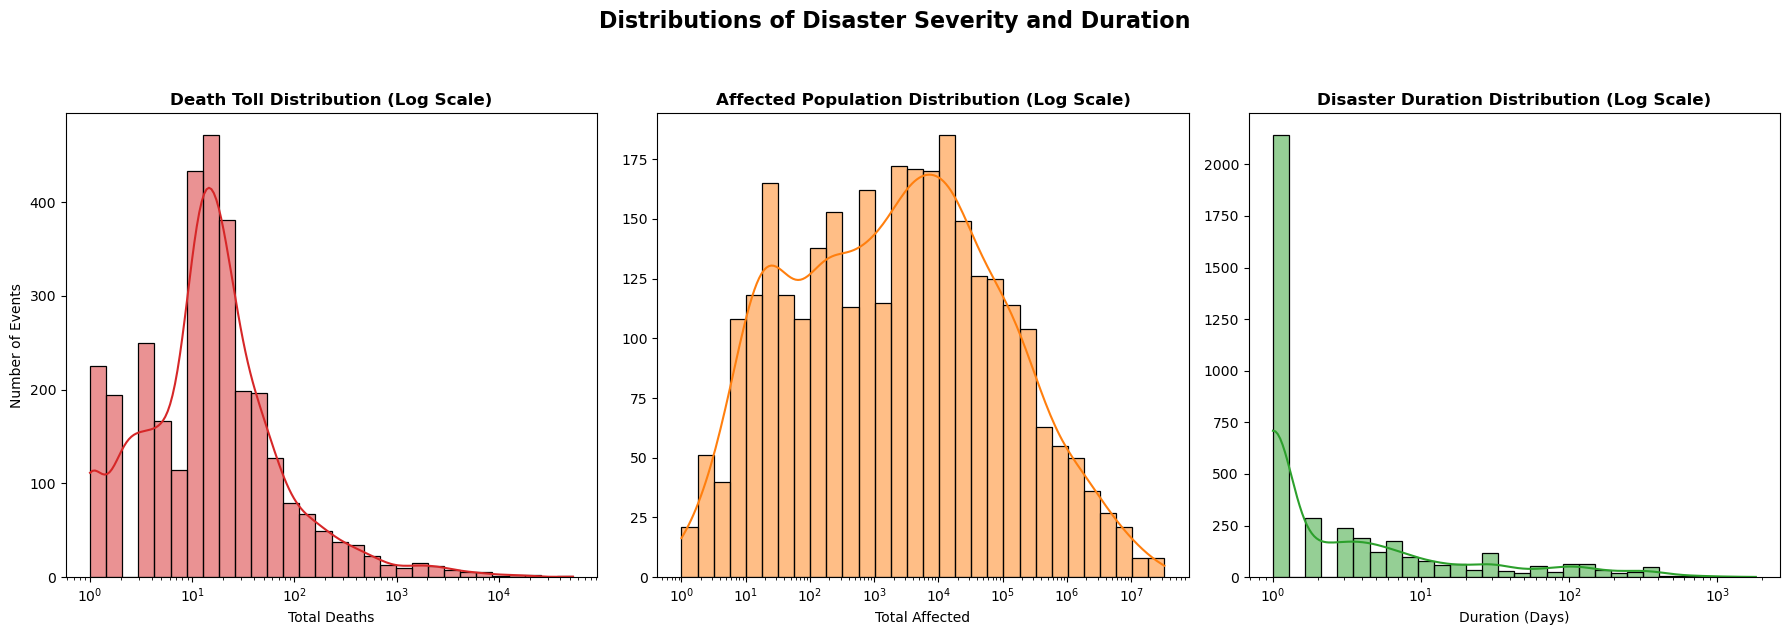

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- A. DATA PREPARATION (Skip this part if df is already in memory) ---
# df = pd.read_csv('public_emdat_custom_request_2018-2024.xlsx - EM-DAT Data.csv')

# Renaming and basic cleaning
if "Total Damage ('000 US$)" in df.columns:
    df.rename(columns={"Total Damage ('000 US$)": 'Total_Damage_USD'}, inplace=True)

# Date construction and duration calculation
df['Start Month'] = df['Start Month'].fillna(1).astype(int)
df['Start Day'] = df['Start Day'].fillna(1).astype(int)
df['End Month'] = df['End Month'].fillna(1).astype(int)
df['End Day'] = df['End Day'].fillna(1).astype(int)

df['Disaster_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)
df['End_Date'] = pd.to_datetime(
    dict(year=df['End Year'], month=df['End Month'], day=df['End Day']),
    errors='coerce'
)

df['Duration_Days'] = (df['End_Date'] - df['Disaster_Date']).dt.days
df['Duration_Days'] = df['Duration_Days'].fillna(1).clip(lower=1)

# Fill missing values (only to avoid plotting errors)
df['Total Deaths'] = df['Total Deaths'].fillna(0)
df['Total Affected'] = df['Total Affected'].fillna(0)

# --- B. VISUALIZATION: DISTRIBUTION ANALYSIS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Death toll distribution (Casualties)
sns.histplot(
    df[df['Total Deaths'] > 0]['Total Deaths'],
    bins=30,
    kde=True,
    ax=axes[0],
    color='#d62728',
    log_scale=True
)
axes[0].set_title('Death Toll Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Total Deaths')
axes[0].set_ylabel('Number of Events')

# 2. Severity / Affected population
sns.histplot(
    df[df['Total Affected'] > 0]['Total Affected'],
    bins=30,
    kde=True,
    ax=axes[1],
    color='#ff7f0e',
    log_scale=True
)
axes[1].set_title('Affected Population Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Total Affected')
axes[1].set_ylabel('')  # intentionally left blank to avoid repetition

# 3. Disaster duration
sns.histplot(
    df[df['Duration_Days'] > 0]['Duration_Days'],
    bins=30,
    kde=True,
    ax=axes[2],
    color='#2ca02c',
    log_scale=True
)
axes[2].set_title('Disaster Duration Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Duration (Days)')
axes[2].set_ylabel('')

plt.suptitle(
    'Distributions of Disaster Severity and Duration',
    fontsize=16,
    fontweight='bold',
    y=1.05
)
plt.tight_layout()
plt.savefig('../images/07_distribution/dist_top15_countries.png', dpi=300, bbox_inches='tight')
plt.show()


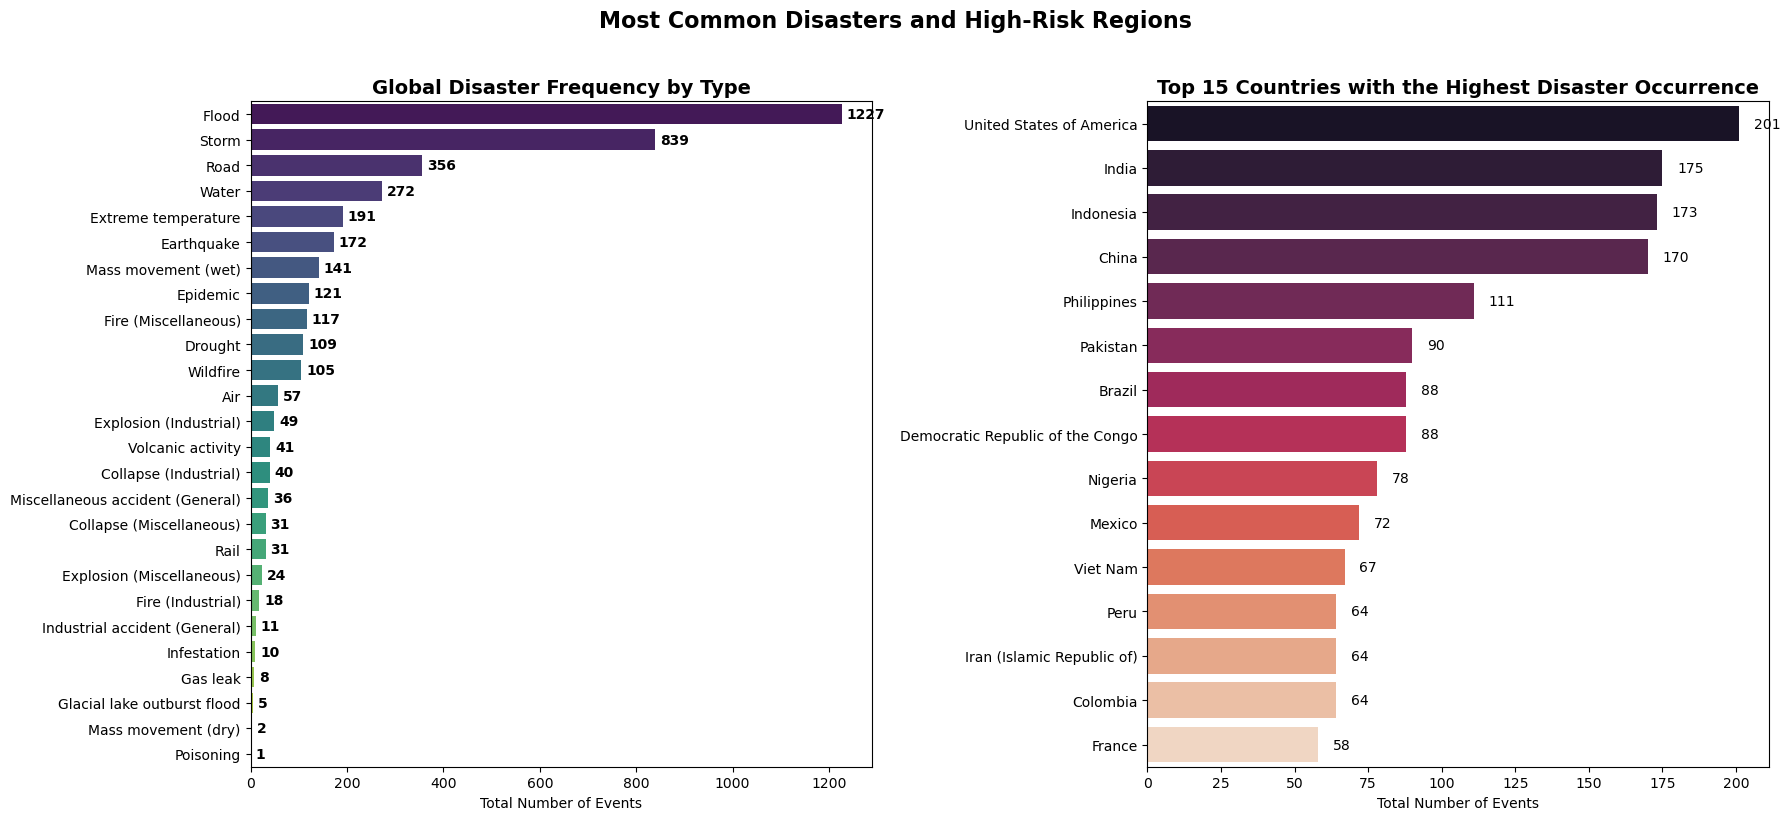

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- VISUALIZATION: FREQUENCY ANALYSIS ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Frequency by Disaster Type
disaster_counts = df['Disaster Type'].value_counts().reset_index()
disaster_counts.columns = ['Disaster Type', 'Count']

sns.barplot(
    data=disaster_counts,
    x='Count',
    y='Disaster Type',
    ax=axes[0],
    palette='viridis',
    hue='Disaster Type'
)
axes[0].set_title('Global Disaster Frequency by Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Number of Events')
axes[0].set_ylabel('')
if axes[0].get_legend() is not None:
    axes[0].get_legend().remove()

# Annotate counts at the end of bars
for i, v in enumerate(disaster_counts['Count']):
    axes[0].text(v + 10, i, str(v), color='black', va='center', fontsize=10, fontweight='bold')

# 2. Countries with the Highest Number of Disasters (Top 15)
top_countries = df['Country'].value_counts().nlargest(15).reset_index()
top_countries.columns = ['Country', 'Count']

sns.barplot(
    data=top_countries,
    x='Count',
    y='Country',
    ax=axes[1],
    palette='rocket',
    hue='Country'
)
axes[1].set_title('Top 15 Countries with the Highest Disaster Occurrence', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Number of Events')
axes[1].set_ylabel('')
if axes[1].get_legend() is not None:
    axes[1].get_legend().remove()

# Annotate counts at the end of bars
for i, v in enumerate(top_countries['Count']):
    axes[1].text(v + 5, i, str(v), color='black', va='center', fontsize=10)

plt.suptitle(
    'Most Common Disasters and High-Risk Regions',
    fontsize=16,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.savefig('../images/07_distribution/dist_disaster_types.png', dpi=300, bbox_inches='tight')
plt.show()
